# NLP: Text Classification Using Transfer Learning with BERT

In this notebook, we explore an effective approach to Natural Language Processing (NLP) using transfer learning with Google’s BERT (Bidirectional Encoder Representations from Transformers) model. Transfer learning allows us to leverage the power of pre-trained models, which have already learned rich contextual embeddings from vast amounts of text data, including books, articles, and websites. By loading BERT with its pre-trained weights, we benefit from the knowledge it has acquired, enabling us to tackle specific classification problems more effectively.

We will fine-tune BERT on our target dataset for sentence classification. This process involves adapting the model to our specific task, allowing it to utilize the powerful representations it learned during pre-training and refine them based on our classification data. Through this method, we can achieve improved performance on NLP tasks with less data and time than training a model from scratch.


## Hugging Face Transformers

The BERT model is sourced from Hugging Face's `transformers` package, an open-source provider of advanced natural language processing (NLP) technologies. The `transformers` library includes a wide range of pre-trained models suitable for diverse NLP tasks.

In this notebook, we will use the TensorFlow 2 interface from Hugging Face’s `transformers` package. This library provides various pre-trained transformer models (e.g., PyTorch `BertModel` or TensorFlow `TFBertModel`) and task-specific variants (e.g., PyTorch `BertForSequenceClassification` or TensorFlow `TFBertForSequenceClassification`) designed for classification and other specialized tasks.

## Dataset

We utilize a corpus of emails to classify them into one of two categories: spam and non-spam (ham). The dataset comprises labeled emails, with ham represented by label 0 and spam by label 1.

You can access the dataset here: [Spam Filter Dataset on Kaggle](https://www.kaggle.com/karthickveerakumar/spam-filter).


Install the following libraries:
- pip install tensorflow-addons
- pip install transformers


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import auc

import tensorflow as tf
import tensorflow_addons as tfa

import transformers
from transformers import BertTokenizer, TFBertModel

/var/folders/zd/2ty0m0yn1jzc2zjgq1154kkxxmbbr2/T/ipykernel_17613/3575115893.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/mhasan2/anaconda3/envs/ml_env/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: ht

In [2]:
print("TensorFlow Version: ", tf.__version__)
print("Transformers Version: ", transformers.__version__)

TensorFlow Version:  2.12.0
Transformers Version:  4.46.0


## Load Data and Analyze

Load data from the CSV file as a Pandas DataFrame object.

In [3]:
df = pd.read_csv('/Users/mhasan2/Library/CloudStorage/OneDrive-UniversityofNebraska-Lincoln/Datasets/emails.csv')

# Display the dataset and relevant info
print(df.head())
print("\nDataset info:")
print(df.info())


# Check if there are any null values
has_null = df.isna().values.any()
print("\nSamples have null values: ", has_null)



# ==================================================

'''
This dataset does not contain any missing values. 
However, if you are working with a dataset that does have missing values, 
please uncomment the following code and execute it.
'''


# # Drop the null values
# if(has_null):
#     df = df[df['content'].notna()]

# # Reset the index after dropping rows
# df.reset_index(drop=True, inplace=True)

# # Make sure to confirm there are no null values left
# print("\nSamples have null values after drop: ", df.isna().values.any())


# ==================================================



print("\nDimension of the data: ", df.shape)

no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("\nNo. of Rows: %d" % no_of_rows)
print("No. of Columns: %d" % no_of_columns)

print("\nClass Distribution")
df.groupby('spam').count()

                                                text  spam
0  Subject: naturally irresistible your corporate...     1
1  Subject: the stock trading gunslinger  fanny i...     1
2  Subject: unbelievable new homes made easy  im ...     1
3  Subject: 4 color printing special  request add...     1
4  Subject: do not have money , get software cds ...     1

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB
None

Samples have null values:  False

Dimension of the data:  (5728, 2)

No. of Rows: 5728
No. of Columns: 2

Class Distribution


,text
spam,
0,4360
1,1368


## Create Separate Arrays for the Features (Sentences) and Labels

In [4]:
sentences_all = df["text"] # DataFrame containing the target 
labels_all = df['spam'] # DataFrame containing the features excluding the target

# Convert the DataFrame objects into NumPy arrays using the NumPy asarray() method
sentences_all = np.asarray(sentences_all) # Data Matrix containing all features excluding the target
labels_all = np.asarray(labels_all) # 1D target array

print("Data Matrix (Sentences) Shape: ", sentences_all.shape)
print("Label array (Labels) Shape: ", labels_all.shape)

print("\nData Matrix (Sentences) Type: ", sentences_all.dtype)
print("Label array (Labels) Type: ", labels_all.dtype)

# Read a random "email" from the data matrix
print("\nA random email:\n")
print(sentences_all[0])

Data Matrix (Sentences) Shape:  (5728,)
Label array (Labels) Shape:  (5728,)

Data Matrix (Sentences) Type:  object
Label array (Labels) Type:  int64

A random email:

Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content manag

## Create Train, Validation, and Test Datasets

In [5]:
sentences_train_all, sentences_val, labels_train_all, labels_val = train_test_split(sentences_all, 
                                                    labels_all, 
                                                    test_size=0.2, 
                                                    random_state=42)

sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences_train_all, 
                                                    labels_train_all, 
                                                    test_size=0.2, 
                                                    random_state=42)

print("Sentences (train) shape: ", sentences_train.shape)
print("Sentences (val) shape: ", sentences_val.shape)
print("Sentences (test) shape: ", sentences_test.shape)


print("\nLabels (train) shape: ", labels_train.shape)
print("Labels (val) shape: ", labels_val.shape)
print("Labels (test) shape: ", labels_test.shape)

Sentences (train) shape:  (3665,)
Sentences (val) shape:  (1146,)
Sentences (test) shape:  (917,)

Labels (train) shape:  (3665,)
Labels (val) shape:  (1146,)
Labels (test) shape:  (917,)


## Token Length Analysis: Statistics and Visualization of Sentence Token Counts in Training Data

To analyze token counts in our training data, we will use BERT’s tokenizer to determine the length of each tokenized sentence. 

First, we instantiate the tokenizer, then for each sentence, we tokenize it (including special `[CLS]` and `[SEP]` tokens) and store its token length in a list for further analysis.



In [6]:
%%time

# Instantiate the BERT tokenizer using the 'bert-base-uncased' model, which lowercase all input text 
#    to ensure uniformity and improve the model's handling of case-insensitive tasks.
tokenizer_count = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# List to store the length of tokens for each sentence
token_lengths = []

# For each sentence in the training data...
for sent in sentences_train:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens
    input_ids = tokenizer_count.encode(sent, add_special_tokens=True)
    #input_ids = tokenizer_count.encode(sent, add_special_tokens=True, max_length=512, truncation=True)
    # Append the length of the tokenized sentence
    token_lengths.append(len(input_ids))


# Calculate statistics
max_len = max(token_lengths)
mean_len = np.mean(token_lengths)
median_len = np.median(token_lengths)

print("\n")
print(f'Max sentence length: {max_len}')
print(f'Mean sentence length: {mean_len}')
print(f'Median sentence length: {median_len}')
print("\n")

Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors




Max sentence length: 9257
Mean sentence length: 366.7443383356071
Median sentence length: 238.0


CPU times: user 5.15 s, sys: 36.1 ms, total: 5.18 s
Wall time: 5.51 s


## Plot the Distribution of Token Counts

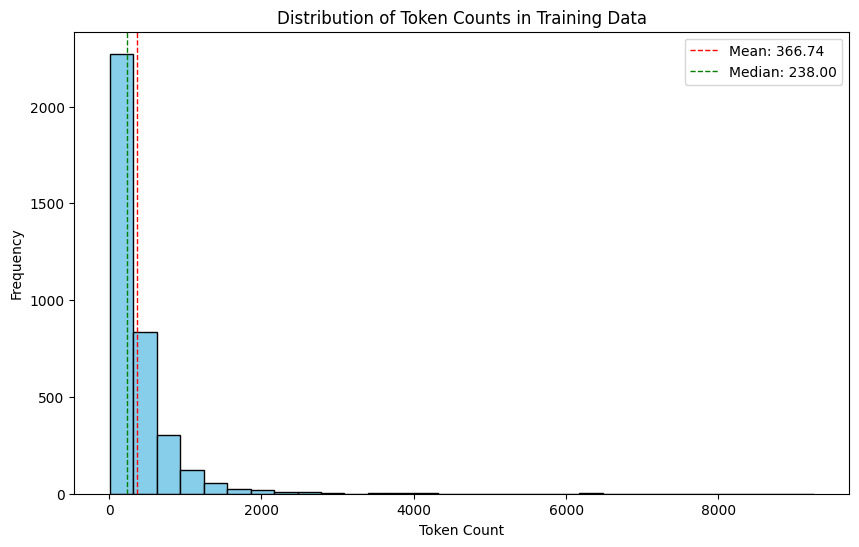

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, color='skyblue', edgecolor='black')
plt.axvline(mean_len, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_len:.2f}')
plt.axvline(median_len, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_len:.2f}')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Distribution of Token Counts in Training Data')
plt.legend()
plt.show()

## Plot Each Sample’s Token Count

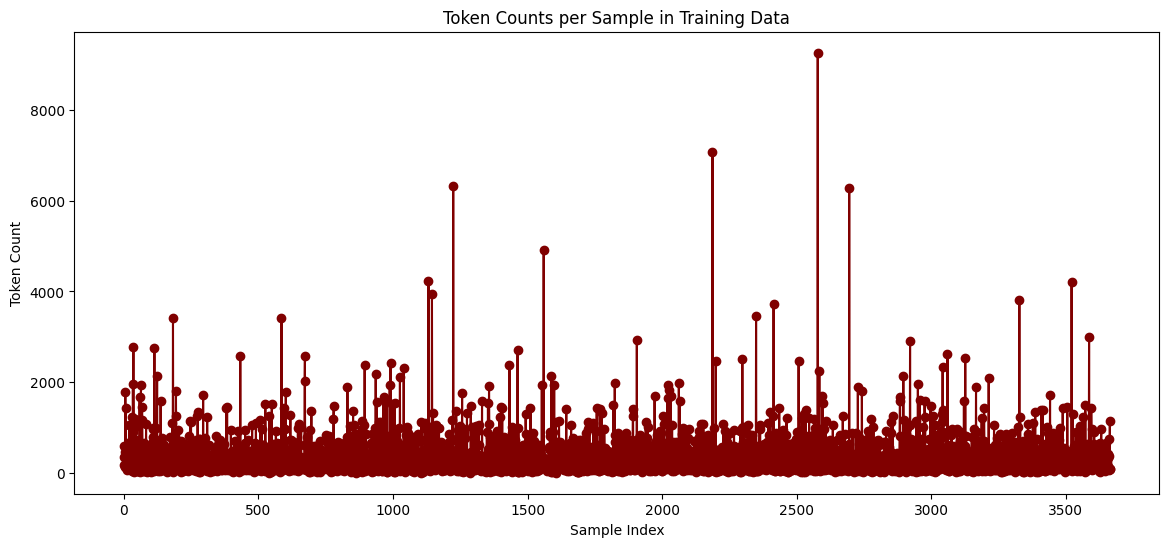

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(range(len(token_lengths)), token_lengths, marker='o', linestyle='-', color='maroon')
plt.xlabel('Sample Index')
plt.ylabel('Token Count')
plt.title('Token Counts per Sample in Training Data')
plt.show()

## Selecting the Maximum Token Length for BERT Training Based on Median Token Count

We will use the **median token count** as the maximum token length for our BERT-based training, as it represents the central tendency of our data without being skewed by outliers. This choice ensures efficient memory usage and minimizes truncation of the majority of sentences.

## Tokenization

Before fine-tuning the BERT model with the data, the text (sentences) must be tokenized, and tokens must be mapped to their respective indices in the tokenizer's vocabulary. For this purpose, we will use the BERT tokenizer.

- **Tokenization Process**:
   - First, we instantiate a tokenizer object with the `from_pretrained` method of the `BertTokenizer` class, which requires a pre-trained model name as an argument:
     
         tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
     
     A full list of pre-trained models is available here: [Pretrained Models](https://huggingface.co/transformers/pretrained_models.html).

   - Next, we apply the tokenization method, which not only tokenizes each sentence but also performs the following steps:
     - **Adds Special Tokens**: Adds special `[CLS]` and `[SEP]` tokens to mark the beginning and end of each sentence.
     - **Pads and Truncates**: Pads and/or truncates sentences to a specified maximum length. For this purpose, we will use the median token count across the dataset as the maximum length to ensure efficient memory usage and model performance.
     - **Applies Attention Mask**: Distinguishes between real and padding tokens with an attention mask.

## Key Tokenization Methods

The base classes `PreTrainedTokenizer` and `PreTrainedTokenizerFast` in the Hugging Face library implement common methods for encoding text for model inputs. See further details on these methods [here](https://huggingface.co/transformers/main_classes/tokenizer.html).

The primary methods include:

- **__call__**: The main method for tokenizing and preparing one or more sequences or pairs of sequences for the model.

- **encode**: Converts a string into a sequence of integer IDs based on the tokenizer's vocabulary.

- **encode_plus**: Tokenizes and prepares a single sequence or a sequence pair, returning additional information, including an attention mask and information on any overflow tokens if a maximum length is specified. **Note**: `encode_plus` is now deprecated, and `__call__` should be used instead.

For more details on tokenization utilities, visit [Tokenization Utilities](https://huggingface.co/transformers/internal/tokenization_utils.html).

In [9]:
# Function for tokenization
def prepare_input(model_tokenizer, sentences, seq_len, model_name):
    
    # Load the tokenizer model using the specified model name
    tokenizer = model_tokenizer.from_pretrained(model_name)

    # Tokenize the list of sentences
    encodings = tokenizer(sentences.tolist(),  # Convert sentences to a list if not already
                          add_special_tokens=True,  # Add special tokens like '[CLS]' for classification and '[SEP]' for separation
                          truncation=True,  # Enable truncation to ensure sequences do not exceed max length
                          padding="max_length",  # Pad sequences to the maximum length specified
                          max_length=seq_len,  # Set the maximum length of the sequences
                          # return_token_type_ids=True,  # Optional: Distinguish between two sentences in a pair
                          return_attention_mask=True,  # Create attention masks to indicate which tokens are padding
                          return_tensors='tf',  # Return the output as TensorFlow tensors
                         )
    
    # Create a list containing the input IDs and attention masks as NumPy arrays
    input = [np.array(encodings["input_ids"]), np.array(encodings["attention_mask"])]
    
    # Return the input list
    return input


In [10]:
# Use the median token count as the maximum length to ensure efficient memory usage and model performance.

# Convert to integer
median_len = np.int32(median_len) 


print(f'Median sentence length: {median_len}')
MAX_SEQ_LEN = median_len
MODEL_NAME = 'bert-base-uncased'

model_tokenizer = BertTokenizer

# Prepare the input sequences via tokenization and formatting
X_train = prepare_input(model_tokenizer, sentences_train, MAX_SEQ_LEN, MODEL_NAME)
X_val = prepare_input(model_tokenizer, sentences_val, MAX_SEQ_LEN, MODEL_NAME)
X_test = prepare_input(model_tokenizer, sentences_test, MAX_SEQ_LEN, MODEL_NAME)


# Create the labels
y_train = labels_train
y_val = labels_val
y_test = labels_test


print("\nTrain data (tokenized) shape: ", len(X_train[0]))
print("Val data (tokenized) shape: ", len(X_val[0]))
print("Test data (tokenized) shape: ", len(X_test[0]))

Median sentence length: 238

Train data (tokenized) shape:  3665
Val data (tokenized) shape:  1146
Test data (tokenized) shape:  917


## Functions for Model Creation, Fine-Tuning, and Weight Loading


The `create_model` function **creates a new model** by instantiating a BERT model from a pre-trained version. Specifically, it uses the `from_pretrained` method of the `Model` class (which refers to a BERT model) to load the pre-trained weights and architecture, but it sets up a new TensorFlow Keras model that includes additional layers for specific tasks, such as pooling and output layers. 

So while it does incorporate a pre-trained BERT model, it constructs a new model that can be fine-tuned for a particular task, such as text clssification.

In [11]:
def create_model(MAX_SEQ_LEN, Model, pretrained_model_name):
    # Define the input for token IDs (the sequence of tokens for each sentence) with a fixed length of MAX_SEQ_LEN.
    # This will hold the integer IDs for tokens in each input sentence.
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_ids')
    
    # Define the input for the attention mask, which specifies which tokens are actual words (1) vs. padding tokens (0).
    # This helps the model focus only on actual words during processing.
    input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='attention_mask')
    
    # Group the two inputs, input_ids and input_mask, into a list as required by the BERT model's input format.
    inputs = [input_ids, input_mask]
    
    # Load the pretrained BERT model specified by the 'pretrained_model_name' argument.
    # 'Model' is typically the class (e.g., TFBertModel) that you use to load BERT in TensorFlow.
    bert = Model.from_pretrained(pretrained_model_name)
    
    # Pass the inputs (input_ids and attention_mask) through the BERT model.
    # The output contains several elements, and we will use 'last_hidden_state', which holds the hidden states
    # for each token in the input sequence.
    bert_outputs = bert(inputs)
    last_hidden_states = bert_outputs.last_hidden_state
    
    # Apply Global Average Pooling to the last hidden states across the sequence length.
    # This reduces the output of BERT into a single vector by averaging the token representations.
    avg = tf.keras.layers.GlobalAveragePooling1D()(last_hidden_states)
    
    # Add a Dense layer with a sigmoid activation function for binary classification (output values between 0 and 1).
    # This output layer will output a single probability value for each input sequence.
    output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
    
    # Create the final model that takes in input_ids and input_mask as inputs and outputs the probability.
    model = tf.keras.Model(inputs=inputs, outputs=output)
    
    # Print the model's architecture for a summary of layers and parameters.
    model.summary()
    
    # Return the constructed model for training or inference.
    return model



def fine_tune(model, epochs, batch_size, best_weights_file_name, X_train, X_val, y_train, y_val):
    # Set up the optimizer for training. Here, we use the Rectified Adam optimizer (RAdam) from TensorFlow Addons.
    # RAdam adapts the learning rate based on the training data, with an initial learning rate of 3e-5.
    opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
    
    # Define the loss function as Binary Crossentropy, which is suitable for binary classification tasks.
    # This measures how well the model’s predicted probabilities match the true labels.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    
    # Specify a file to save the best model weights during training.
    best_weights_file = best_weights_file_name
    
    # Set up a ModelCheckpoint callback to save the model's best weights based on the validation AUC metric.
    # This will save only the weights (not the entire model) each time the validation AUC improves.
    # Mode 'max' ensures that higher AUC values are better.
    m_ckpt = tf.keras.callbacks.ModelCheckpoint(
        best_weights_file, monitor='val_auc', mode='max', verbose=1,
        save_weights_only=True, save_best_only=True
    )
    
    # Compile the model with the defined loss function, optimizer, and evaluation metrics.
    # The metrics include:
    # - AUC (Area Under the ROC Curve): Useful for assessing the performance of binary classifiers.
    #    AUC is a threshold-independent metric, meaning it reflects the model’s ability to distinguish 
    #    between classes across different decision boundaries. In an imbalanced dataset, AUC is particularly 
    #    valuable because it provides insight into the model’s performance beyond simple accuracy, which can be misleading.
    #    This metric will be more sensitive to the minority class, which accuracy alone might not fully capture.
    # - Binary Accuracy: Calculates how often predictions match binary labels.
    #                    For binary classification tasks, use BinaryAccuracy rather than accuracy 
    #                    to get a clearer picture of how well your model is performing.
    model.compile(
        loss=loss, 
        optimizer=opt, 
        metrics=[tf.keras.metrics.AUC(curve="ROC"),
                 tf.keras.metrics.BinaryAccuracy()]
    )
    
    # Train (fine-tune) the model on the training data, and validate it on the validation data.
    # Parameters:
    # - epochs: Number of times to iterate over the entire training dataset.
    # - batch_size: Number of samples to process before updating model weights.
    # - validation_data: Data to evaluate model performance after each epoch.
    # - callbacks: The ModelCheckpoint callback to save the best weights.
    # - verbose: Display progress (1 for showing progress, 0 for silent).
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[m_ckpt],
        verbose=1
    )
    
    # Return the history of the training process, which includes metrics over each epoch for analysis.
    return history



def load_model(MAX_SEQ_LEN, Model, pretrained_model_name, best_weights_file_name):
    # Create a model using the specified maximum sequence length, model class, and pre-trained model name.
    # This initializes the architecture of the model but does not yet load any weights.
    model = create_model(MAX_SEQ_LEN, Model, pretrained_model_name)
    
    # Define the loss function to be used during evaluation. 
    # Binary Cross entropy is chosen here as we are dealing with a binary classification problem.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    
    # Load the previously saved weights from the specified file.
    # This retrieves the best weights determined during the fine-tuning process.
    model.load_weights(best_weights_file_name)
    
    # Set up the optimizer for the model, using the Rectified Adam optimizer (RAdam) with a learning rate of 3e-5.
    # This optimizer helps in stabilizing the training process and improving convergence.
    opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
    
    # Compile the model with the defined loss function, optimizer, and evaluation metrics.
    # The metrics include:
    # - AUC (Area Under the ROC Curve): Useful for assessing the performance of binary classifiers.
    #    AUC is a threshold-independent metric, meaning it reflects the model’s ability to distinguish 
    #    between classes across different decision boundaries. In an imbalanced dataset, AUC is particularly 
    #    valuable because it provides insight into the model’s performance beyond simple accuracy, which can be misleading.
    #    This metric will be more sensitive to the minority class, which accuracy alone might not fully capture.
    # - Binary Accuracy: Calculates how often predictions match binary labels.
    #                    For binary classification tasks, use BinaryAccuracy rather than accuracy 
    #                    to get a clearer picture of how well your model is performing.
    model.compile(
        loss=loss, 
        optimizer=opt, 
        metrics=[tf.keras.metrics.AUC(curve="ROC"),
                 tf.keras.metrics.BinaryAccuracy()]
    )
    
    # Return the fully initialized model
    return model


## Model Creation

Create a new model using the BERT architecture. We use the 'bert-base-uncased' model, which is a version of BERT that does not distinguish between uppercase and lowercase letters, making it suitable for tasks where case sensitivity is not crucial, such as sentiment analysis and general text classification.

In [12]:
# Create the classification model
model = create_model(MAX_SEQ_LEN, TFBertModel, 'bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 238)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 238)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 238,                                           

## Fine-tune the Model

In [13]:
%%time

epochs = 2
batch_size = 16
best_weights_file_name = "weights_BERT_email.h5"

history = fine_tune(model, epochs, batch_size, best_weights_file_name, X_train, X_val, y_train, y_val)

Epoch 1/2


2024-10-28 21:14:50.302353: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


230/230 [==============================] - ETA: 0s - loss: 0.2270 - auc: 0.9483 - binary_accuracy: 0.8977
Epoch 1: val_auc improved from -inf to 0.99882, saving model to weights_BERT_email.h5
230/230 [==============================] - 875s 4s/step - loss: 0.2270 - auc: 0.9483 - binary_accuracy: 0.8977 - val_loss: 0.0383 - val_auc: 0.9988 - val_binary_accuracy: 0.9860
Epoch 2/2
230/230 [==============================] - ETA: 0s - loss: 0.0315 - auc: 0.9991 - binary_accuracy: 0.9894
Epoch 2: val_auc improved from 0.99882 to 0.99956, saving model to weights_BERT_email.h5
230/230 [==============================] - 898s 4s/step - loss: 0.0315 - auc: 0.9991 - binary_accuracy: 0.9894 - val_loss: 0.0238 - val_auc: 0.9996 - val_binary_accuracy: 0.9930
CPU times: user 4h 52min 24s, sys: 1h 4min 14s, total: 5h 56min 39s
Wall time: 29min 33s


In [18]:
# Print the keys of the history
print("Keys in history: ", history.history.keys())

Keys in history:  dict_keys(['loss', 'auc', 'binary_accuracy', 'val_loss', 'val_auc', 'val_binary_accuracy'])


## Learning Curves (Binary Accuracy & Loss)

In [14]:
def plot_learning_curves(history, numOfEpochs, title):
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_binary_accuracy'],label='validation', color="r")
    plt.plot(range(1,numOfEpochs+1),history.history['binary_accuracy'],label='training', color="b")
    plt.legend(loc=0, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xlim([1,numOfEpochs])
    #plt.ylim([0, 1])
    plt.grid(True)
    plt.title("Model Accuracy: "+title)
    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation', color="r")
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training', color="b")
    plt.legend(loc=0, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.xlim([1,numOfEpochs])
    #plt.ylim([0, 1])
    plt.grid(True)
    plt.title("Model Loss: "+title)
    
    plt.show() 

Epochs:  2


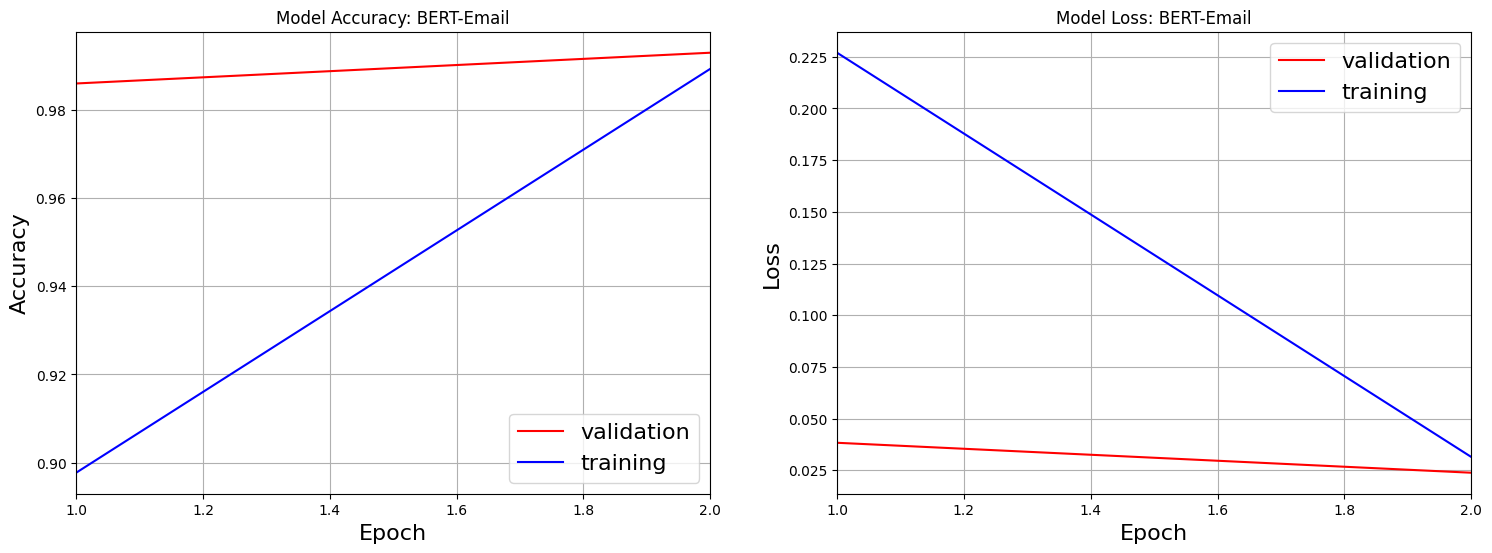

In [15]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

plot_learning_curves(history, numOfEpochs, "BERT-Email")

## Evaluate the Model

In [16]:
%%time

numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']


train_loss = history.history['loss']
val_loss = history.history['val_loss']


# Read the last value from the list that represents final epoch statistics
print("\nTrain Accuracy: {:.3f}".format(train_acc[-1]))
print("Train Loss: {:.3f}".format(train_loss[-1]))

print("\nValidation Accuracy: {:.3f}".format(val_acc[-1]))
print("Validation Loss: {:.3f}".format(val_loss[-1]))


'''
Evaluate the model on the test data
'''

# Predict probabilities for the test data
y_test_predicted_proba = model.predict(X_test)
print("\nShape of the predictions array: ", y_test_predicted_proba.shape)
print("Data type of the predictions array: ", y_test_predicted_proba.dtype)


# Create an array to store predicted binary labels
y_test_predicted = y_test_predicted_proba

# Convert the predicted probabilities into binary labels
for i in range(len(y_test_predicted_proba)):
    if(y_test_predicted_proba[i] >= 0.5):
        y_test_predicted[i] = 1
    else:
        y_test_predicted[i] = 0

        
print(y_test_predicted.shape)        
y_test_predicted = y_test_predicted.ravel()
print(y_test_predicted.shape)  

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: {:.3f}".format(test_accuracy))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  2

Train Accuracy: 0.989
Train Loss: 0.031

Validation Accuracy: 0.993
Validation Loss: 0.024
29/29 [==============================] - 63s 2s/step

Shape of the predictions array:  (917, 1)
Data type of the predictions array:  float32
(917, 1)
(917,)

Test Accuracy: 0.996

Test Confusion Matrix:
[[705   2]
 [  2 208]]

Test Precision = 0.990476
Test Recall = 0.990476
Test F1 Score = 0.990476

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       0.99      0.99      0.99       210

    accuracy                           1.00       917
   macro avg       0.99      0.99      0.99       917
weighted avg       1.00      1.00      1.00       917

CPU times: user 10min 27s, sys: 1min 18s, total: 11min 46s
Wall time: 1min 2s


## Evaluate the Model on Test Data Using the Saved Weights

In [17]:
# Specify the filename for saving the best model weights during training
best_weights_file_name = "weights_BERT_email.h5"

# Load the pre-trained BERT model along with the best weights saved during training for evaluation
print("Loading the saved model weights ...")
model_saved = load_model(MAX_SEQ_LEN, TFBertModel, 'bert-base-uncased', best_weights_file_name)



'''
Evaluate the model on the test data
'''

# Predict probabilities for the test data
y_test_predicted_proba = model_saved.predict(X_test)
print("\nShape of the predictions array: ", y_test_predicted_proba.shape)
print("Data type of the predictions array: ", y_test_predicted_proba.dtype)


# Create an array to store predicted binary labels
y_test_predicted = y_test_predicted_proba

# Convert the predicted probabilities into binary labels
for i in range(len(y_test_predicted_proba)):
    if(y_test_predicted_proba[i] >= 0.5):
        y_test_predicted[i] = 1
    else:
        y_test_predicted[i] = 0

        
print(y_test_predicted.shape)        
y_test_predicted = y_test_predicted.ravel()
print(y_test_predicted.shape)  

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: {:.3f}".format(test_accuracy))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_predicted))

Loading the saved model weights ...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 238)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 238)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 238,                                         